In [97]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("device: ", device)

torch.__version__

device:  cuda


'2.5.1'

In [98]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# Константы
num_trajectories = 368  # Количество траекторий
num_radars = 16  # Количество радаров
data_path = 'last_data'  # Путь к данным
# input_features = ['x_measure', 'y_measure', 'z_measure',
#                   'v_x_measure', 'v_y_measure', 'v_z_measure',
# 
#                   'r_measure', 'theta_measure', 'fi_measure',
#                   'v_r_measure', 'v_theta_measure', 'v_fi_measure',
# 
#                   'r_mean', 'theta_mean', 'fi_mean',
#                   'r_error', 'theta_error', 'fi_error',
#                   ]  # Входные признаки

input_features = ['x_measure', 'v_x_measure', 'r_measure', 'theta_measure', 'fi_measure',
                  'r_mean', 'theta_mean', 'fi_mean',
                  'r_error', 'theta_error', 'fi_error']  # Входные признаки

# input_features = ['x_measure','theta_mean']
target_feature = 'x_true'  # Целевая координата

def load_trajectory_data(traj_idx):
    trajectory_data = []
    for radar_idx in range(1, num_radars + 1):
        file_path = os.path.join(data_path, f'traj{traj_idx}_radar{radar_idx}.csv')
        df = pd.read_csv(file_path)
        trajectory_data.append(df)
    
    # Объединение данных по временной оси для одного радара
    return trajectory_data

# Подготовка данных
X_data, y_data = [], []

for traj_idx in range(1, num_trajectories + 1):
    trajectory_data = load_trajectory_data(traj_idx)
    
    # Для каждого радара, собираем последовательность (seq_length, num_features)
    radar_data = []
    radar_targets = []  # Список для целевых значений для каждого радара
    for radar_idx in range(num_radars):
        data = trajectory_data[radar_idx]
        X = data[input_features].values  # Входные данные для радарa
        y = data[target_feature].values  # Истинная координата
        
        radar_data.append(X)
        radar_targets.append(y)
    
    # Преобразуем данные в форму (num_radars, seq_length, num_features)
    X_data.append(np.array(radar_data))  # (num_radars, seq_length, num_features)
    y_data.append(np.array(radar_targets)) # (num_radars, seq_length)

# Преобразуем в numpy массивы
X_data = np.array(X_data)  # (num_trajectories, num_radars, seq_length, num_features)
y_data = np.array(y_data)  # (num_trajectories, num_radars, seq_length)

# Заменяем NaN на 0 и Inf на большое число
X_data = np.nan_to_num(X_data, nan=0.0, posinf=1e6, neginf=-1e6)
y_data = np.nan_to_num(y_data, nan=0.0, posinf=1e6, neginf=-1e6)

# Теперь транспонируем X_data, y_data чтобы размерность стала (num_trajectories * num_radars, seq_length, num_features)
# X_data_raw = X_data.reshape(-1, X_data.shape[2], X_data.shape[3])  # (num_trajectories * num_radars, seq_length, num_features)
# y_data_raw = y_data.reshape(-1, y_data.shape[2])  # (num_trajectories * num_radars, seq_length)

# Проверим размерность данных
# print(X_data_raw.shape)  # (368*16, seq_length, num_features) 
# print(y_data_raw.shape)  # (368*16, seq_length)
print(X_data.shape)  # (368*16, seq_length, num_features) 
print(y_data.shape)  # (368*16, seq_length)


(368, 16, 1001, 11)
(368, 16, 1001)


In [99]:
train_size = int(0.8 * len(X_data))
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]
print(X_train.shape, X_test.shape)

(294, 16, 1001, 11) (74, 16, 1001, 11)


In [100]:
class RadarDataset(Dataset):
    def __init__(self, X, y, window_size=234, step=12):
        self.windows_X = []
        self.windows_y = []
        
        for trajectory_idx in range(X.shape[0]):  # 368 траекторий
            trajectory_X = X[trajectory_idx]  # (16, 1001, 11)
            trajectory_y = y[trajectory_idx]  # (16, 1001)
            
            # Конкатенируем данные от 16 радаров
            trajectory_X = trajectory_X.transpose(1, 0, 2).reshape(1001, -1)  # (1001, 11*16)
            trajectory_y = trajectory_y.mean(axis=0)  # Среднее значение x для всех радаров (1001,)
            
            for start in range(0, 1001 - window_size, step):
                end = start + window_size
                self.windows_X.append(trajectory_X[start:end, :])
                self.windows_y.append(trajectory_y[end-1])
        
        self.windows_X = torch.tensor(np.array(self.windows_X), dtype=torch.float32)
        self.windows_y = torch.tensor(np.array(self.windows_y), dtype=torch.float32)
        
    def __len__(self):
        return len(self.windows_X)
    
    def __getitem__(self, idx):
        return self.windows_X[idx], self.windows_y[idx]
    


In [101]:
# from sklearn.preprocessing import StandardScaler
# import torch
# 
# # Создаем скейлеры
# X_scaler = StandardScaler()
# y_scaler = StandardScaler()
# 
# # Нормализация X (признаки)
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()
# 
# for i in range(16):  # По всем радарам отдельно
#     X_train_scaled[:, i, :, :] = torch.tensor(
#         X_scaler.fit_transform(X_train[:, i, :, :].reshape(-1, 11)).reshape(1001, 11),
#         dtype=torch.float32
#     )
#     X_test_scaled[:, i, :, :] = torch.tensor(
#         X_scaler.transform(X_test[:, i, :, :].reshape(-1, 11)).reshape(1001, 11),
#         dtype=torch.float32
#     )
# 
# # Нормализация y (целевая переменная)
# y_train_scaled = torch.tensor(
#     y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape),
#     dtype=torch.float32
# )
# y_test_scaled = torch.tensor(
#     y_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape),
#     dtype=torch.float32
# )
# 
# # Теперь передаем в RadarDataset
# train_dataset = RadarDataset(X_train_scaled, y_train_scaled)
# test_dataset = RadarDataset(X_test_scaled, y_test_scaled)


In [105]:
# #################################### NORMALIZE ####################################################
# 
# from sklearn.preprocessing import StandardScaler
# 
# # Нормализуем данные
# train_scaler = StandardScaler()
# test_scaler = StandardScaler()
# # Пример нормализации для X (признаки)
# X_train_scaled = torch.tensor(train_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape), dtype=torch.float32)
# X_test_scaled = torch.tensor(test_scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape), dtype=torch.float32)
# 
# # Для y (цели) можно тоже использовать нормализацию или просто масштабировать в тот же диапазон
# y_train_scaled = torch.tensor(train_scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape), dtype=torch.float32)
# y_test_scaled = torch.tensor(test_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape), dtype=torch.float32)
# 
# print(X_train_scaled.shape)
# 
# 
# train_dataset = RadarDataset(X_train_scaled, y_train_scaled)
# test_dataset = RadarDataset(X_test_scaled, y_test_scaled)

In [102]:
# Создание датасета и DataLoader
train_dataset = RadarDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = RadarDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Пример батча
print(len(train_loader), len(test_loader))
for X_batch, y_batch in train_loader:
    print(X_batch.shape)  # (16, seq_length, num_features) для каждого батча
    # print(X_batch.view(-1, X_batch.shape[2], X_batch.shape[3]).shape)
    print(y_batch.shape)  # (16, seq_length)
    # print(y_batch.view(-1).shape)
    print(X_batch[0][233][:17], y_batch[0])
    break

294 74
torch.Size([64, 234, 176])
torch.Size([64])
tensor([3.3451e+04, 8.7604e-02, 3.5428e+04, 1.5884e+00, 3.3514e-01, 0.0000e+00,
        4.3740e-02, 0.0000e+00, 1.5183e+00, 2.1854e-03, 1.4503e-03, 3.3431e+04,
        6.0621e-02, 3.5424e+04, 1.5645e+00, 3.3698e-01, 0.0000e+00]) tensor(33428.6992)


In [48]:
# def make_windows(X, y, window_size, step): 
#     windows_X = []
#     windows_y = []
#     for idx in range(X.shape[0]):
#         trajectory_X = X[idx]  # (1001, 16)
#         trajectory_y = y[idx]  # (1001)
# 
#         for start in range(0, trajectory_X.shape[0] - window_size, step):
#             end = start + window_size
#             windows_X.append(trajectory_X[start:end, :])  # Окно данных
#             windows_y.append(trajectory_y[end-1])  # Целевая координата в конце окна
#     
#     windows_X = np.array(windows_X)  # (16*количество окон, 100, 16)
#     windows_y = np.array(windows_y)  # (16*количество окон,)
#     
#     return torch.tensor(windows_X, dtype=torch.float32), torch.tensor(windows_y, dtype=torch.float32)   
#     
# X_data, y_data  = make_windows(X_data_raw, y_data_raw, 234, 12) # check determ   
# print(X_data.shape) 
# print(y_data.shape) 
# print(len(X_data))

In [49]:
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# 
# class RadarDataset(Dataset):
#     def __init__(self, X, y, window_size=1000):
#         self.X = X
#         self.y = y
#         self.window_size = window_size
#         
#     def __len__(self):
#         return self.X.shape[0]  # Количество траекторий
#     
#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]
#     
# # Параметры для DataLoader
# window_size = 936 #если брать меньше, то больше обучающая выборка, но оперативы не хватает
# batch_size = 128
# 
# train_size = int(0.8 * len(X_data))
# X_train, X_test = X_data[:train_size], X_data[train_size:]
# y_train, y_test = y_data[:train_size], y_data[train_size:]
# print(X_train.shape, X_test.shape)

In [51]:
# train_dataset = RadarDataset(X_train, y_train, window_size=window_size)
# test_dataset = RadarDataset(X_test, y_test, window_size=window_size)
# print(train_dataset[0][0].shape)
# 
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)   # Не перемешиваем данные
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) 
# 
# print("len of loaders", len(train_loader), len(test_loader))
# 
# # Пример батча
# for X_batch, y_batch in train_loader:
#     print(X_batch.shape)  # (16, seq_length, num_features) для каждого батча
#     # print(X_batch.view(-1, X_batch.shape[2], X_batch.shape[3]).shape)
#     print(y_batch.shape)  # (16, seq_length)
#     # print(y_batch.view(-1).shape)
#     print(X_batch[0][199], y_batch[0])
#     break

----------------------------------------------------------------------------------------- MODEL --------------------------------------------------------------------------------

In [107]:
import torch.nn as nn

# Функция инициализации весов с помощью метода Xavier
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)  # Инициализация весов
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # Инициализация смещений нулями
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Инициализация весов
        nn.init.constant_(m.bias, 0)  # Инициализация смещений нулями

class LSTMModel(nn.Module):
    def __init__(self, input_size=176, hidden_size=64, num_layers=2, output_size=1, dropout=0.3):
        super(LSTMModel, self).__init__()
        # LSTM слой
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Полносвязный слой для предсказания координаты x
        self.fc1 = nn.Linear(hidden_size, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)
        # self.fc1 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_len, hidden_size]
        last_hidden_state = lstm_out[:, -1, :]  # Берем последний временной шаг
        out = self.fc1(last_hidden_state)  # Прогнозируем координату x
        out = self.act1(out)
        out = self.fc2(out)
        return out


---------------------------------------------------------------------------------- TRAIN ----------------------------------------------------------------------------------------

In [104]:
from tqdm import tqdm
def train(model, optimizer, scheduler, criterion, loader, epochs, clip_value=1.0):
    history = []
    # for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(loader):
        # for i, (inputs, targets) in tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch+1}/{epochs}'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # inputs = inputs.view(-1, inputs.shape[2], inputs.shape[3]).to(device)
            # targets = targets.view(-1).to(device)
            # Прогноз
            optimizer.zero_grad()
            outputs = model(inputs)
    
            # Вычисление ошибки
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
        
            # Градиентный клипинг
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
            optimizer.step()
    
            running_loss += loss.item()
            
        scheduler.step()
    
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.6f}')
        history.append(running_loss/len(loader))
    return history, model
    

Epoch [1/100], Loss: 6415811815.156463
Epoch [2/100], Loss: 6372121278.088435
Epoch [3/100], Loss: 6332771904.040816
Epoch [4/100], Loss: 6292116630.986395
Epoch [5/100], Loss: 6252479080.224490
Epoch [6/100], Loss: 6213384519.142858
Epoch [7/100], Loss: 6177214204.534014
Epoch [8/100], Loss: 6139753980.636054
Epoch [9/100], Loss: 6101393478.166667
Epoch [10/100], Loss: 6062674878.605442
Epoch [11/100], Loss: 6025743941.062925
Epoch [12/100], Loss: 5991067335.265306
Epoch [13/100], Loss: 5956496165.168367
Epoch [14/100], Loss: 5923397859.013605
Epoch [15/100], Loss: 5888747642.278912
Epoch [16/100], Loss: 5852911135.032313
Epoch [17/100], Loss: 5837652516.712585
Epoch [18/100], Loss: 5785104194.374149
Epoch [19/100], Loss: 5750928981.122449
Epoch [20/100], Loss: 5724733325.227891
Epoch [21/100], Loss: 5690101532.991497
Epoch [22/100], Loss: 5674231023.428572
Epoch [23/100], Loss: 5650490179.821428
Epoch [24/100], Loss: 5616805944.670068
Epoch [25/100], Loss: 5583616861.358844
Epoch [26

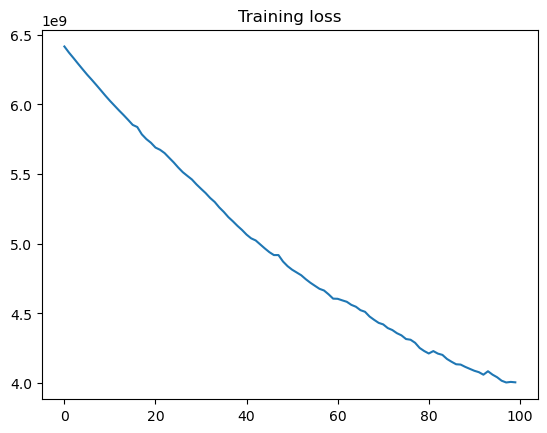

<All keys matched successfully>

In [65]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=176, hidden_size=128, num_layers=2, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)

# Обучение
num_epochs = 100
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

    
torch.save(trained_model.state_dict(), './lstm_model.pth')
trained_model.load_state_dict(torch.load('./lstm_model.pth', weights_only=True))

In [66]:
trained_model.eval()
test_loss = 0.0
test_loss_unscaled = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        # inputs = inputs.view(-1, inputs.shape[2], inputs.shape[3]).to(device)
        # targets = targets.view(-1).to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = trained_model(inputs)
        # print(outputs, targets)
        # unscaled_out = test_scaler.inverse_transform(outputs.cpu())
        # unscaled_targets = test_scaler.inverse_transform(targets.view(-1, 1).cpu())
        # diff = abs(unscaled_out - unscaled_targets)
        # print(unscaled_out, unscaled_targets)
        # print(diff)
        # print()
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
        # test_loss_unscaled += np.sum(diff)

print(f'Validation Loss: {test_loss/len(test_loader):.8f}')

Validation Loss: 4876012221.37837791


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=176, hidden_size=128, num_layers=2, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Обучение
num_epochs = 200
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

    
torch.save(trained_model.state_dict(), './lstm_model.pth')
trained_model.load_state_dict(torch.load('./lstm_model.pth', weights_only=True))

Epoch [1/200], Loss: 65139.970811


Epoch [1/200], Loss: 0.018134
Epoch [2/200], Loss: 0.000871
Epoch [3/200], Loss: 0.000596
Epoch [4/200], Loss: 0.000479
Epoch [5/200], Loss: 0.000407
Epoch [6/200], Loss: 0.000351
Epoch [7/200], Loss: 0.000324
Epoch [8/200], Loss: 0.000327
Epoch [9/200], Loss: 0.000289
Epoch [10/200], Loss: 0.000263
Epoch [11/200], Loss: 0.000250
Epoch [12/200], Loss: 0.000203
Epoch [13/200], Loss: 0.000177
Epoch [14/200], Loss: 0.000183
Epoch [15/200], Loss: 0.000155
Epoch [16/200], Loss: 0.000184
Epoch [17/200], Loss: 0.000162
Epoch [18/200], Loss: 0.000145
Epoch [19/200], Loss: 0.000141
Epoch [20/200], Loss: 0.000118
Epoch [21/200], Loss: 0.000120
Epoch [22/200], Loss: 0.000113
Epoch [23/200], Loss: 0.000110
Epoch [24/200], Loss: 0.000118
Epoch [25/200], Loss: 0.000112
Epoch [26/200], Loss: 0.000098
Epoch [27/200], Loss: 0.000102
Epoch [28/200], Loss: 0.000095
Epoch [29/200], Loss: 0.000091
Epoch [30/200], Loss: 0.000086
Epoch [31/200], Loss: 0.000087
Epoch [32/200], Loss: 0.000075
Epoch [33/200], L

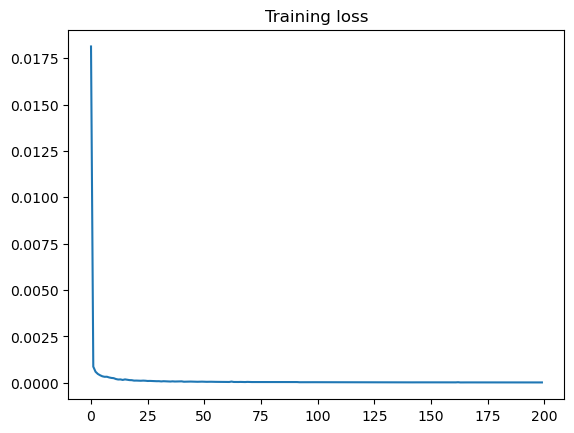

<All keys matched successfully>

In [24]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Инициализируем модель
model = LSTMModel(input_size=32, hidden_size=128, num_layers=2, output_size=1)
model.apply(init_weights)

model.to(device)

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=1)

# Обучение
num_epochs = 200
training_history, trained_model = train(model, optimizer, exp_lr_scheduler, criterion, train_loader, num_epochs)

plt.plot(np.arange(num_epochs), training_history)
plt.title("Training loss")
plt.show()

    
torch.save(trained_model.state_dict(), './lstm_model.pth')
trained_model.load_state_dict(torch.load('./lstm_model.pth', weights_only=True))

------------------------------------------------------------------------------------------------ VALIDATION -----------------------------------------------------------------------


In [26]:
# Тестирование
# train_loader
# test_loader
trained_model.eval()
test_loss = 0.0
test_loss_unscaled = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        # inputs = inputs.view(-1, inputs.shape[2], inputs.shape[3]).to(device)
        # targets = targets.view(-1).to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = trained_model(inputs)
        # print(outputs, targets)
        # unscaled_out = test_scaler.inverse_transform(outputs.cpu())
        # unscaled_targets = test_scaler.inverse_transform(targets.view(-1, 1).cpu())
        # diff = abs(unscaled_out - unscaled_targets)
        # print(unscaled_out, unscaled_targets)
        # print(diff)
        # print()
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
        # test_loss_unscaled += np.sum(diff)

print(f'Validation Loss: {test_loss/len(test_loader):.8f}')
# print(f'Validation Loss_true: {test_loss_unscaled/len(train_loader):.8f}')

Validation Loss: 1.94674204
Validation Loss_true: 2873391.11310649
